In [1762]:
from tqdm.notebook import tqdm
import numpy as np
import statsmodels.api as sm
import pandas as pd
import joblib
from numpy.random import normal

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
from scipy import stats
%matplotlib inline

In [1741]:
def get_coef_significance(X, Y):    
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y
    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    return pd.read_html(summary.as_html(), header=0, index_col=0)[0], lin_reg

In [1742]:
def check_pval(pval):
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [1743]:
def ttest(x, y, randomized=False, verbose=False):
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    s_x = np.var(x, ddof=1)
    s_y = np.var(y, ddof=1)
    
    if randomized:
        b0 = n_x ** 0.75
        b1 = n_y ** 0.75
        
        dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
        
        
        theta_x = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b0)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_x // 4 + 1))
        
        theta_x = theta_x[:n_x]
    #     theta_x = theta_x / np.linalg.norm(theta_x)

        theta_y = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b1)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_y // 4 + 1))
        
        theta_y = theta_y[:n_y]
    #     theta_y = theta_y / np.linalg.norm(theta_y)

        t_val = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
        p = 2*(stats.t.cdf(-abs(t_stat_rand), dof))
        
    else: 
        t_val, p = stats.ttest_ind(x, y, equal_var=False) 
        
    if verbose:
        check_pval(p)
    return p

## Генерация данных

In [1765]:
def generate_data(control_size, scale, hist_size=5_000, seed=37):
    np.random.seed(seed)


    M_hist = hist_size
    X_hist = np.hstack([
        normal(0.0, 1.0, M_hist).reshape(M_hist, 1),
        normal(0.0, 1.0, M_hist).reshape(M_hist, 1),
        normal(0.0, 1.0, M_hist).reshape(M_hist, 1)
    ])

    scale = 2.5
    M_control = control_size
    X_control = np.hstack([
        normal(0.0, 1.0, M_control).reshape(M_control, 1),
        normal(0.0, 1.0, M_control).reshape(M_control, 1),
        normal(0.0, 1.0, M_control).reshape(M_control, 1)
    ])

    M_experiment = int(M_control * scale)
    X_experiment = np.hstack([
        normal(0.0, 1, M_experiment).reshape(M_experiment, 1),
        normal(0.0, 1, M_experiment).reshape(M_experiment, 1),
        normal(0.0, 1, M_experiment).reshape(M_experiment, 1)
    ])


    w = np.array([0.5, 0.3, 0.7])
    n = w.shape[0]
    b1 = 0.4
    b2 = 0.5


    lambda_hist = np.exp(X_hist @ w + b1 + normal(0.0, 0.01, M_hist))

    lambda_control = np.exp(X_control @ w + b1 + normal(0.0, 0.01, M_control))
    lambda_experiment = np.exp(X_experiment @ w + b2 + normal(0.0, 0.01, M_experiment))

    y_hist = np.random.poisson(lambda_hist)
    y_control = np.random.poisson(lambda_control)
    y_experiment = np.random.poisson(lambda_experiment)
    
    
    X_control = np.hstack((X_control, 
                           np.zeros_like(X_control[:, 0]).reshape(-1, 1), 
                           y_control.reshape(-1, 1)))
                          
    X_experiment = np.hstack((X_experiment, 
                              np.ones_like(X_experiment[:, 0]).reshape(-1, 1), 
                              y_experiment.reshape(-1, 1)))
                             
    X_hist = np.hstack((X_hist, 
                        np.zeros_like(X_hist[:, 0]).reshape(-1, 1), 
                        y_hist.reshape(-1, 1)))
    
    columns = [f"f{i}" for i in range(0, n)]
    columns += ['treatment', 'visit']
    
    X_control = pd.DataFrame(X_control, columns=columns)
    X_experiment = pd.DataFrame(X_experiment, columns=columns)
    X_hist = pd.DataFrame(X_hist, columns=columns)
    
    return X_control, X_experiment, X_hist 

In [1771]:
scale = 2.5
X_control, X_experiment, X_hist = generate_data(2_000, scale, 5_000, seed=37)

Text(0.5, 1.0, 'Experiment sample')

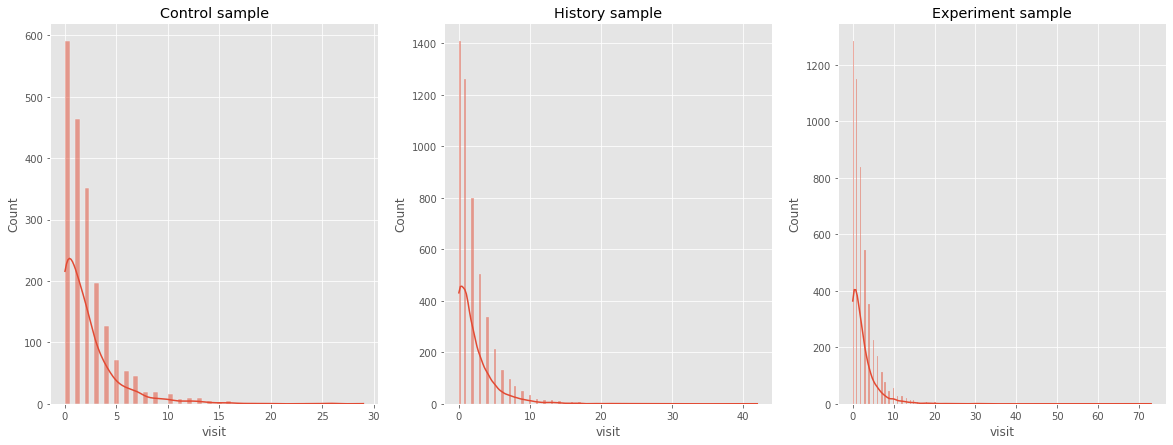

In [1767]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
sns.histplot(X_control['visit'], kde=True, ax=ax1)
ax1.set_title('Control sample')

sns.histplot(X_hist['visit'], kde=True, ax=ax2)
ax2.set_title('History sample')

sns.histplot(X_experiment['visit'], kde=True, ax=ax3)
ax3.set_title('Experiment sample')

In [1768]:
data = [[stats.ttest_ind(X_control['visit'], X_experiment['visit'], equal_var=False).pvalue,
       stats.ttest_ind(X_hist['visit'], X_experiment['visit'], equal_var=False).pvalue,
       stats.ttest_ind(X_control['visit'], X_hist['visit'], equal_var=False).pvalue]]

pd.DataFrame(data, columns = ['C&E', 'H&E', 'C&H'], index=['pvalue'])

,C&E,H&E,C&H
pvalue,0.000162,2.868084e-07,0.861076


# Методы

## Множественная регрессия

In [1744]:
def modify_with_regression_test(control, experimental, control_hist, experimental_hist, columns, verbose=False, aa=False):
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")
    
    if aa:
        experimental['treatment'] = 1
        
    Z = pd.concat((control, experimental, control_hist, experimental_hist), axis=0).sample(frac=1)
    means = np.mean(Z[columns])

    Y = Z['visit']
    X = Z[columns]
    X = X - means.values
    X = pd.concat((X, Z['treatment']), axis=1)

    table_summary, model = get_coef_significance(sm.tools.tools.add_constant(X), Y)
    p_after = table_summary.iloc[-1, :]['P>|t|']
    
    return p_after

## CUPED 

In [1745]:
def modify_with_cuped(control, experimental, control_hist, experimental_hist, columns, verbose=False):
    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)
    
    Y = X['visit']
    X = X[columns]
    
    means = np.mean(X)
    X = X - means

    reg = Pipeline(
        [
            ("regressor", linear_model.LinearRegression()),
        ]
    )
    reg.fit(X, Y)

    c = control[columns] - means
    e = experimental[columns] - means

    

    y_c = control['visit']
    y_e = experimental['visit']


    control_cuped = y_c - reg.predict(c) + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()
    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}\n")
    
    
    p_before = ttest(y_c, y_e)
    
    p_after = ttest(control_cuped, experimental_cuped)
    return p_before, p_after

## Бустинг

In [1746]:
def modify_with_gb(control, experimental, control_hist, experimental_hist, columns, verbose=False):

    if verbose:
        print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)


    Y = X['visit']
    X = X[columns]
    
    means = np.mean(X)
    X = X - means

    reg = Pipeline(
        [
            ("regressor", GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=2).fit(X, Y)),
        ]
    )
    reg.fit(X, Y)

    c = control[columns] - means
    e = experimental[columns] - means
    


    y_c = control['visit']
    y_e = experimental['visit']

    

    control_cuped = y_c - reg.predict(c)  + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()

    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}\n")
    
    
    p_before = ttest(y_c, y_e)
    
    p_after = ttest(control_cuped, experimental_cuped)
    return p_before, p_after

In [1870]:
def draw_graphics(before=None, after_cup=None, after_gb=None, p_after_reg=None, title='', alpha=0.05, sizes=shapes):
    if len(title) != 0:
        print('\n', title, '\n')
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    ax1.plot(sizes, [alpha] * len(sizes), color="red", linestyle='dashed', label='alpha')
    if not (before is None):
        ax1.plot(sizes, before, marker='o', ms=5, label='Default')
        ax2.plot(sizes, np.log(before), marker='o', ms=5, label='Default')
    if not (after_cup is None):
        ax1.plot(sizes, after_cup, marker='o', ms=5, label='CUPED')
        ax2.plot(sizes, np.log(after_cup), marker='o', ms=5, label='CUPED')
    if not (after_gb is None):
        ax1.plot(sizes, after_gb, marker='o', ms=5, label='CUPAC')
        ax2.plot(sizes, np.log(after_gb), marker='o', ms=5, label='CUPAC')
    if not (p_after_reg is None):
        ax1.plot(sizes, p_after_reg, marker='o', ms=5, label='Ml-rate')
        ax2.plot(sizes, np.log(p_after_reg), marker='o', ms=5, label='Ml-rate')
    ax1.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax1.set_ylabel('p-value', fontsize=15)
#     ax1.set_title(f'Поведение p-value в зависимости от размера выборки', fontsize=15)

    ax2.plot(sizes, [np.log(alpha)] * len(sizes), color="red", linestyle='dashed', label='alpha')
    ax2.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax2.set_ylabel('log p-value', fontsize=15)
#     ax2.set_title(f'Поведение log p-value в зависимости от размера выборки',fontsize=15)

    ax1.legend(fontsize='x-large')
    ax2.legend(fontsize='x-large')

# Сравнение методов на искусственных данных

In [1816]:
sizes = [100, 200, 400, 600, 800]


scale = 2.5
cols = ['f0', 'f1', 'f2']
cols_regr = ['f0', 'f2']

all_pvals_b = []
all_pvals_c = []
all_pvals_gb = []
all_pvals_reg = []

n_iter = 100
control_size = 2000

for i in tqdm(range(0, n_iter)):
    X_control_temp, X_experiment_temp, X_hist_temp = generate_data(control_size, scale, 5_000, seed=i)
    
    cur_pvals_b = []
    cur_pvals_c = []
    cur_pvals_gb = []
    cur_pvals_reg = []
    for j in range(0, control_size // 100, 2):
        control = X_control_temp[: 100 * j + control_size // 10]
        experiment = X_experiment_temp[: int(scale * (100 * j + control_size // 10))]

        
        p_bef, p_aft_cup = modify_with_cuped(control,  experiment, 
                                    X_hist_temp[X_hist_temp['treatment'] == 0], 
                                    X_hist_temp[X_hist_temp['treatment'] == 1], cols)
    
        p_bef, p_aft_gb = modify_with_gb(control,  experiment, 
                                    X_hist_temp[X_hist_temp['treatment'] == 0],
                                    X_hist_temp[X_hist_temp['treatment'] == 1], cols)

        p_aft_reg = modify_with_regression_test(control,  experiment, 
                                    X_hist_temp[X_hist_temp['treatment'] == 0],
                                    X_hist_temp[X_hist_temp['treatment'] == 1], cols_regr)
        cur_pvals_b.append(p_bef)
        cur_pvals_c.append(p_aft_cup)
        cur_pvals_gb.append(p_aft_gb)
        cur_pvals_reg.append(p_aft_reg)
    
    all_pvals_b.append(cur_pvals_b)
    all_pvals_c.append(cur_pvals_c)
    all_pvals_gb.append(cur_pvals_gb)
    all_pvals_reg.append(cur_pvals_reg)
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [1817]:
pvals_c = pd.DataFrame(all_pvals_c)
# pvals_c = pvals_c.set_axis(sizes)

pvals_gb = pd.DataFrame(all_pvals_gb)
# pvals_gb = pvals_gb.set_axis(sizes)

pvals_b = pd.DataFrame(all_pvals_b)
# pvals_b = pvals_b.set_axis(sizes)

pvals_reg = pd.DataFrame(all_pvals_reg)
# pvals_reg = pvals_reg.set_axis(sizes)

In [1857]:
pvals_c = pvals_c.T.set_axis(sizes[1:])

pvals_gb = pvals_gb.T.set_axis(sizes[1:])

pvals_b = pvals_b.T.set_axis(sizes[1:])

pvals_reg = pvals_reg.T.set_axis(sizes[1:])

In [1861]:
data_cuped = None
for i in range(pvals_c.shape[1]):
    data_cuped = pd.concat([data_cuped, pvals_c.iloc[:, i]])
    
data_grad_boost = None
for i in range(pvals_gb.shape[1]):
    data_grad_boost = pd.concat([data_grad_boost, pvals_gb.iloc[:, i]])
    
    
data_before = None
for i in range(pvals_b.shape[1]):
    data_before = pd.concat([data_before, pvals_b.iloc[:, i]])

data_reg = None
for i in range(pvals_reg.shape[1]):
    data_reg = pd.concat([data_reg, pvals_reg.iloc[:, i]])

In [1824]:
sizes = list(range(0, 2200, 200))
sizes[1:]

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

In [1871]:
sns.reset_defaults()

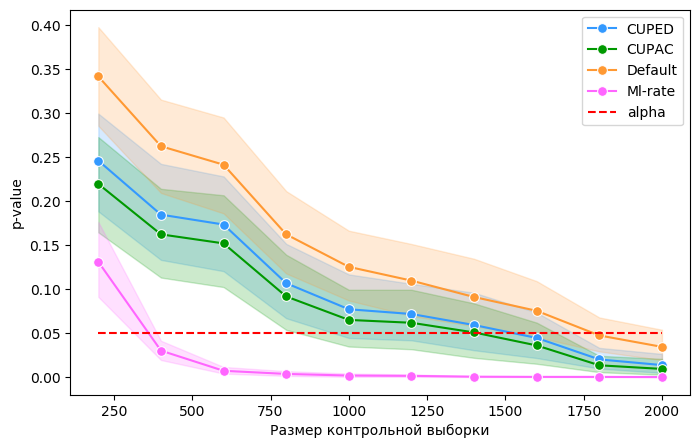

In [1873]:
#with std

f = plt.subplots(1, figsize=(8, 5))
sns.lineplot(data=data_cuped, label='CUPED', marker="o", markersize=7, color='#3399ff')
sns.lineplot(data=data_grad_boost, label='CUPAC', marker="o", markersize=7, color='#009900')
sns.lineplot(data=data_before, label='Default', marker="o", markersize=7, color='#ff9933')
sns.lineplot(data=data_reg, label='Ml-rate', marker="o", markersize=7, color='#ff66ff')

plt.plot(sizes[1:], [0.05] * len(sizes[1:]), color="#ff0000", linestyle='dashed', label='alpha')
# plt.title('Зависимость параметра p-value оцененного по 10 запускам от размера выборки')
plt.xlabel('Размер контрольной выборки')
plt.ylabel('p-value')
plt.legend()
plt.show()